## Creating a Word2Vec model

Ok, now that we now som basic concepts about distributed semantic models and word2vec in specific, let's try to implement the latter with a real dataset, from "The Simpsons" TV series.

The following diagram shows the general process we will follow in notebook
<img src="Images/process_2.png" height="300" width="1100">

## Requirements

This notebook is written in Python3 and needs the following libraries:

* **pandas**        _(pip install pandas)_
* **numpy**         _(python -m pip install --user numpy)_
* **gensim**        _(pip install --upgrade gensim)_
* **tqdm**          _(pip install tqdm)_
* **matplotlib**    _(python -m pip install -U matplotlib)_
* **sklearn**       _(pip install -U scikit-learn)_
* **SpaCy**         _(python3 -m pip install spacy)_ --> python -m spacy download en
* **testfixtures**  _(pip install testfixtures)_
* **adjustText**    _(pip install adjustText)_
* **umap**          _(pip install umap-learn)_

To make sure which one you already have and which you should install, try to run the cell with the title **Loading libraries** and install the missing libraries accordingly.

<img src="Images/header.png" width="1200" >

To run practical examples I use the Simpsons [dataset from Kaggle](https://www.kaggle.com/pierremegret/dialogue-lines-of-the-simpsons/download)  which consists more that 150k lines and covers more than 600(old!) episodes.

### Loading libraries

In [5]:
pip install testfixtures

  Obtaining dependency information for testfixtures from https://files.pythonhosted.org/packages/1a/ac/9ed001c4b3d0eb3d0642391b51579f872092dbd97b2918cfa557b0c50141/testfixtures-8.0.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 5.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import spacy
import re
import os
import pandas as pd
import itertools
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import warnings
import umap.umap_ as umap # pip install umap-learn
import seaborn as sns
from adjustText import adjust_text # pip install adjustText

import gensim.parsing as gm
from gensim.parsing.preprocessing import preprocess_string
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec # pip install testfixtures

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

### Defining some parameters

In [7]:
plt.rcParams['figure.figsize'] = (15, 10)
warnings.filterwarnings('ignore')

### Loading data from CSV file

In [8]:
df = pd.read_csv('./Datasets/simpsons_dataset.csv',
                sep=',').dropna().reset_index(drop=True)
df.sample(10)

,raw_character_text,spoken_words
5115,Romantic Lover Voice,"""Join me at the Gilded Truffle this Saturday a..."
34573,Herman Hermann,"Now this baby is called ""The Withstandinator""...."
84533,John Squawking Bear,"In the name of the Great Turtle, will you answ..."
49640,Bart Simpson,Pledge drive?
131851,Ralph Wiggum,Does that mean you were crazy?
54601,Lisa Simpson,Practicing tennis.
63374,Bart Simpson,The doorman died.
107843,Bart Simpson,I'm on it.
18612,Kang,Foolish earthling. Totally unprepared for the ...
127262,Thomas Jefferson,That all men are created equal.


### Pre-Processing

Like any other ML task, we should start our work by preprocessing the data. To start, let's use gensim's text processing tools to define a function. Consider that this function is created for this specific dataset. For example, it doesn't clean html tags, URLs,... since we know that they won't be present in our data. As you can see, I commented out the stem_text function since we later use SpaCy to Lemmatize the text. (More on Lemmatization :
[Lemmatization Approaches with Examples in Python](https://www.machinelearningplus.com/nlp/lemmatization-examples-python/) )

In [9]:
def text_preproc(text: str):
    """Performs pre-processing steps on the given string.
    
    Pre-processing is done using methods from gensim module.
    Methods are hard-coded in the function.
    
    Args:
        text: A string
    
    Returns:
        A list with tokenized and Pre-processed tokens of the given string.
    """

    my_filter = [
        lambda x: x.lower(),
        gm.strip_punctuation,
        gm.strip_multiple_whitespaces,
        gm.strip_numeric,
        gm.remove_stopwords,
        gm.strip_short,
        gm.strip_tags,
        #gm.stem_text
    ]
    return preprocess_string(text, filters=my_filter)

Looking at the *text_preproc* function, you see that I used *remove_stopwords* to eliminate English stopwords from the text. I was convinced that this step is necessary but seeing [this](https://stackoverflow.com/a/40447086/5842939) answer on StackOverflow, I think removing or not removing stopwords actually doesn't change anything since the creators of the word2vec algorithm already thought about that!

In [11]:
# grabbing the column which contains the text
text_column = 'spoken_words'
data = df[text_column]

# passing texts to the function we defined above
training_set_raw = []
for d in tqdm_notebook(data, desc='Pre-Processing: Cleaning'):
    training_set_raw.append((text_preproc(d)))

# initialize spacy 'en' model
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# creating sentences from tokens
training_sentence = [' '.join(d) for d in training_set_raw]

# lmmatizing sentences
training_set_0 = []
for ts in tqdm_notebook(training_sentence, desc='Pre-Processing: Lemmatizing'):
    doc = nlp(ts)
    lemm = [token.lemma_ for token in doc]
    if len(lemm) is not 0:
        training_set_0.append(lemm)

# removing duplicated data
training_set = []
for l in tqdm_notebook(training_set_0, desc='Pre-Processing: Deduplicating'):
    if l not in training_set:
        training_set.append(l)

Pre-Processing: Cleaning:   0%|          | 0/131853 [00:00<?, ?it/s]

Pre-Processing: Lemmatizing:   0%|          | 0/131853 [00:00<?, ?it/s]

Pre-Processing: Deduplicating:   0%|          | 0/125951 [00:00<?, ?it/s]

In [12]:
# let's see the result of our pre-processing for the first 5 sentences
for i,j in zip(data[:5], training_set[:5]):
    print(f"-{i}\n-{' '.join(j)}")
    print('-'*40)

-No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it.
-actually little disease magazine news show natural think
----------------------------------------
-Where's Mr. Bergstrom?
-bergstrom
----------------------------------------
-I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. What did he teach you?
-know sure like talk touch lesson plan teach
----------------------------------------
-That life is worth living.
-life worth live
----------------------------------------
-The polls will be open from now until the end of recess. Now, just in case any of you have decided to put any thought into this, we'll have our final statements. Martin?
-poll open end recess case decide think final statement martin
----------------------------------------


### N-Grams

In this particular case, we want to embed words using their neighbours, the words are frequently appearing (or doesn't appear) close to them. Imagine that you want to calculate the occurrence probability of a set of three words : 
$$P(w_{1},w_{2},w_{3})$$
We can write it in this way:
$$P(w_{1},w_{2},w_{3}) = P(w_{1})P(w_{2}\mid w_{1})P(w_{3}\mid w_{1} w_{2})$$

The general form of this formula is named Chain Rule:

$$P(w_{1},w_{2},w_{3},...,w_{n}) = P(w_{1})P(w_{2}\mid w_{1})...P(w_{n}\mid w_{1}...w_{n-1})$$

$$or$$

$$P(w_{1}w_{2}...w_{i} )=\prod  P(w_{i}\mid w_{1} w_{2}...w_{i-1})$$

_if you're interested in this topic, take a look at [this video](https://www.youtube.com/watch?v=dkUtavsPqNA
)_

Ok, let's calculate the bigrams for our sentences. To do so, we use the Phrases class from Gensim library. According to its documentation, Phrases automatically detect common phrases – multi-word expressions / word n-grams – from a stream of sentences.

In [13]:
def create_ngrams(data: list, log: bool = True, n=2):
    """Creates ngrams(2-3) from the given list of tokenized and cleaned data.
    
    Args:
        data: a list of ([tokens], key) pairs.
        log: If True, it prints the status.
        
    Returns : 
        A Gensim Trigram object.
    """
    if log:
        print("Learning lexicon from files...")

    if log:
        print("Creating Bigrams...")
    ngrams = Phrases(data, min_count=30)
    
    if log:
        print("Bigrams are Ready.")
    if n ==3:
        if log:
            print("Creating Trigrams...")
        ngrams = Phrases(ngrams[data], min_count=10, threshold=2)
        if log:
            print("Trigrams are ready to use.")

    return ngrams

In [14]:
ngram = create_ngrams(training_set, n=2)

Learning lexicon from files...
Creating Bigrams...
Bigrams are Ready.


Let's take a look at our bigrams:

In [15]:
bb = Phrases(training_set, min_count=30)
for sent in training_set:
    bigrams_ = [b for b in bb[sent] if ' ' in b ]
    if bigrams_ != []:
        print(bigrams_)

Oops! It seems the only bigram we got is **going to** !
Well, this is not a good thing because:
1. It's almost impossible that **going to** is the only bigram in our dataset
2. Even if **going to** is the only bigram, it's not *useful* at all! (*It lacks something called 'Informativeness'*)

Where this **going to** came from? According to documents of *gensim* library, they use *collection counts* to calculate bigrams, which is not a good idea for several reasons, especially when we have a small dataset like ours.
Unfortunately, the reason behind it and the better way to identify bigrams is out of the scope of this notebook so for now, let's use what we have.

In [20]:
def get_or_build_model(ngram: Phrases=None,
                       skipgram: int=0,
                       size: int=300,
                       window: int=2,
                       min_count: int=20,
                       alpha=0.03, 
                       negative=20,
                       hs: int=1,
                       ns_exponent = 0.05,
                       epochs=10,
                       load: str=None,
                       save: str=None,
                       log: bool=True):
    
    """Build or if a saved model exists, load the model.

    Args: 
        ngram: ngram object created by create_ngrams() function.
        skipgram: internal algorithm used to create the model. 0=CBOW, 1=skipgram. [default = 0]
        size: Dimensionality of the word vectors.
        window: Maximum distance between the current and predicted word within a sentence.
        min_count: Ignores all words with total frequency lower than this.
        alpha: The initial learning rate
        hs: hierarchical softmax if 0 non-zero, negative sampling will be used.[default = 1]
        load: file path to the pre-built model to be loaded. If None, model will be created [default = None]
        save: file path to be used to save the created model. If None, model won't be saved locally [default = None]
        log: whether log messages should be printed for the use [default = True]
    
    Returns:
        A word2vec model
        
    """
    if load is not None:
        if log:
            print("Loading model...")
        model = Word2Vec.load(f"./{load}")
        if log:
            print("Model has been loaded successfully.")
        return model
    
    else:
        if log:
            print("Creating ngrams...")
            sentences = [ngram[pair] for pair in tqdm_notebook(training_set)]
        if log:
            print("Building Word2Vec...")
        model = Word2Vec(
            sentences,
            vector_size=size,
            window=window,
            min_count=min_count,
            sg=skipgram,
            hs=hs,
            alpha=alpha, 
            negative=negative,
            ns_exponent = ns_exponent,
            epochs=epochs)
        if log:
            print("Model has been built.")
        if save is not None:
            if log:
                print("Saving the model...")
            model.save(f"./{save}")
            if log:
                print("Model has been saved successfully.")

        return model

In [21]:
# creating Word2Vec model
model = get_or_build_model(ngram)

Creating ngrams...


  0%|          | 0/105305 [00:00<?, ?it/s]

Building Word2Vec...
Model has been built.


### Cosine Similarity

Cosine similarity is the Cosine of two vectors A and B in a Way that if they are orthogonal to each other(not similarity), the Cosine will be 0, and in case they are equal, the Cosine would be equal to 1.

$$similarity\,score = cos(\theta ) = \frac{A \cdot B}{\left \| A  \right \| \left \| B  \right \|} =\frac{\sum_{i=1}^{n}A_{i}B_{i}}{\sqrt{\sum_{i=1}^{n}A_{i}^{2}} \sqrt{\sum_{i=1}^{n}B_{i}^{2}}}$$

Since Cosine similarity is one of the most important text similarity measures and has a pivotal role in text mining and NLP, let's make sure that its idea is clear. To better understand it, we can *turn* a bit the equation and look at the dot product:

$$a.b = \left | a \right |\times \left | b \right | \times \cos( \theta)$$

The above equation means : *to get the dot product of two vectors __a__ and __b__ you should consider the angle between them*

But why? let's first remind ourselves of the goal of a dot-product:combining two vectors to obtain their product. So we can expect that having vectors as ingredients, we need to consider all their characteristics which, as we mentioned before, are magnitude and direction. for example, looking at the following simple example, we can see that it's trivial to think that given that both vectors have the same directions, it's possible to say that we can obtain the multiplication of these vectors by multiplying their lengths:

But the things won't always remain as simple as we have seen above. Look at this example:

The three vectors $\overrightarrow{a}, \overrightarrow{b}$ and $\overrightarrow{c}$ have the same length ($\left | a \right | = \left | b \right | = \left | c \right |$) but we in order to calculate $a.b$ or $a.c$ we can't just simply multiply their lengths because we can just do such a thing only if two vectors have the same direction. So, we need somehow to convert one of the vectors to have the same direction as the other vector. The way we can achieve this is to use the trigonometry Cosine function. As you can see in the figure above, after converting  $\overrightarrow{b}$ and  $\overrightarrow{c}$ using Cosine function we can see that $b.a$ will be greater than $c.a$.

The situation we face dealing with words will differ from the example above in 2-dimensional space. As we said before, even if we are going to use dense vectors instead of the sparse outcome of one-hot encoding, the vector space still would be too complex to be visually demonstrated. In the figure above, we see a 3-dimensional vector space with three vectors. Even without actually calculating dot products, we can almost certainly say that $a.b$ is greater than $a.c$ given that $\phi$ the angle between $a$ and $b$ is close to $90^{\circ}$ which brings $c.b$ close to zero. As a result, we can see that in our case of word vectors, we can expect that similar vectors have a greater dot product with respect to the dissimilar vectors.
Now that we're familiar with the dot product, we can *turn* the formula again and see it as:

$$cos(\theta ) = \frac{A \cdot B}{\left \| A  \right \| \left \| B  \right \|}$$

A really useful characteristic of $cos(\theta ) $ is that in this case, it will be a value between 0 and 1, with 0 showing the minimum and 1 the maximum similarity of two vectors. That's why we can use cosine similarity to calculate the similarity between two word vectors. In the following section, we will see cosine similarity in action:

In [22]:
def n_most_similar(model: Word2Vec,
                   text: str,
                   n: int = 10):
    """Prints the n most similar words of the given string.

    Args:
        model : An object of Word2Vec class, created by get_or_build_model().
        text : the string we want to get it similar words.
        n : number of similar words we want to get [default = 10]        
    """

    most_similar_to = model.wv.most_similar(positive=[text], topn=n)
    for i, similar_item in enumerate(most_similar_to):
        similar_key = similar_item[0]
        score = str(round(float(similar_item[1]), 2))
        print(f"{i+1} - {similar_key} -- {score}")


Let's calculate the 10 most similar words to **Bart** character:

In [23]:
n_most_similar(model, text='bart', n=10)

1 - lisa -- 0.62
2 - eliza -- 0.49
3 - won -- 0.44
4 - abraham -- 0.4
5 - dad -- 0.4
6 - marge -- 0.4
7 - mom_dad -- 0.4
8 - babysitter -- 0.4
9 - milhouse -- 0.4
10 - coward -- 0.4


The results are really good considering not so large dataset we have in hand.
Now let's directly use **.doesnt_match** method of model vocabulary to see which of the given words doesn't belong to the rest of the words:

In [24]:
model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

In [25]:
model.wv.doesnt_match(["bart", "lisa", "milhouse"])

'milhouse'

### Visualization

How do you think we can visualize the results of our word-embedding model? the short answer is, we can't! :D
Simply because we are human beings and our brain can't comprehend an object which has more than 3 dimensions! _(reminder: in our example, we've created 300-dimension vectors!)_

So what is the solution? Fortunately, in 2008 a smart guy named _Laurens van der Maaten_ came up with a method that can reduce a high-dimension model to a 2-3 dimension space.
This technique is called __t-SNE__, which stands for __t-Distributed Stochastic Neighbor Embedding__. Explanation of t-SNE is way beyond the scope of this class, but if you're interested in the topic, here is an excellent video which explains how does it work:[link](https://www.youtube.com/watch?v=NEaUSP4YerM) 

_Note: Remember that getting a good result from t-SNE is not so easy! there are LOTS of parameters you can/should modify inside t-SNE function. [Here](https://distill.pub/2016/misread-tsne/) is a super-useful article with an interactive tool that helps you to play with parameters and discover their impact on the final results._

In [36]:
def plot_tsne(model,
              n_components: int=2,
              perplexity:int =20,
              learning_rate: int=10,
              n_iter: int=1000,
              metric: str='euclidean'):
    
    """t-SNE plot for word-embedding model.
    
    Args:
        model: Word2Vec model
        n_components: Dimension of the embedded space.
        perplexity: The perplexity is related to the number of nearest neighbors that
            is used in other manifold learning algorithms. Larger datasets
            usually require a larger perplexity. 
        learning_rate: The learning rate for t-SNE is usually in the range [10.0, 1000.0].
            If the learning rate is too high, the data may look like a 'ball' with any
            point approximately equidistant from its nearest neighbours.
        n_iter: Maximum number of iterations for the optimization. Should be at least 250.
        metric: The metric to use when calculating distance between instances in a 
            feature array.
    """

    X = model.wv[model.wv.key_to_index.keys()]
    # diminesion reduction from 300 to 50 with PCA
    X = PCA(n_components=50).fit_transform(X)

    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate=learning_rate,
        n_iter=n_iter,
        metric=metric)

    X_tsne = tsne.fit_transform(X)
    plt.figure(figsize=(13, 8))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=2, alpha=0.4)
    plt.title('t-SNE plot', fontsize=20)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [41]:
def plot_umap(model,
              n_components: int=2,
              n_neighbors:int =3,
              learning_rate: int=10,
              metric: str='cosine'):
    
    """UMAP plot for word-embedding model.
    
    Args:
        n_components: Dimension of the embedded space.
        metric: The metric to use when calculating distance between instances in a 
            feature array.
    """
    
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric=metric, learning_rate=learning_rate)
    X = model.wv[model.wv.key_to_index.keys()]
    embedding = reducer.fit_transform(X)
    plt.scatter(embedding[:, 0], embedding[:, 1], s=5, alpha=0.5)
    plt.title('UMAP plot', fontsize=24)
    plt.show()

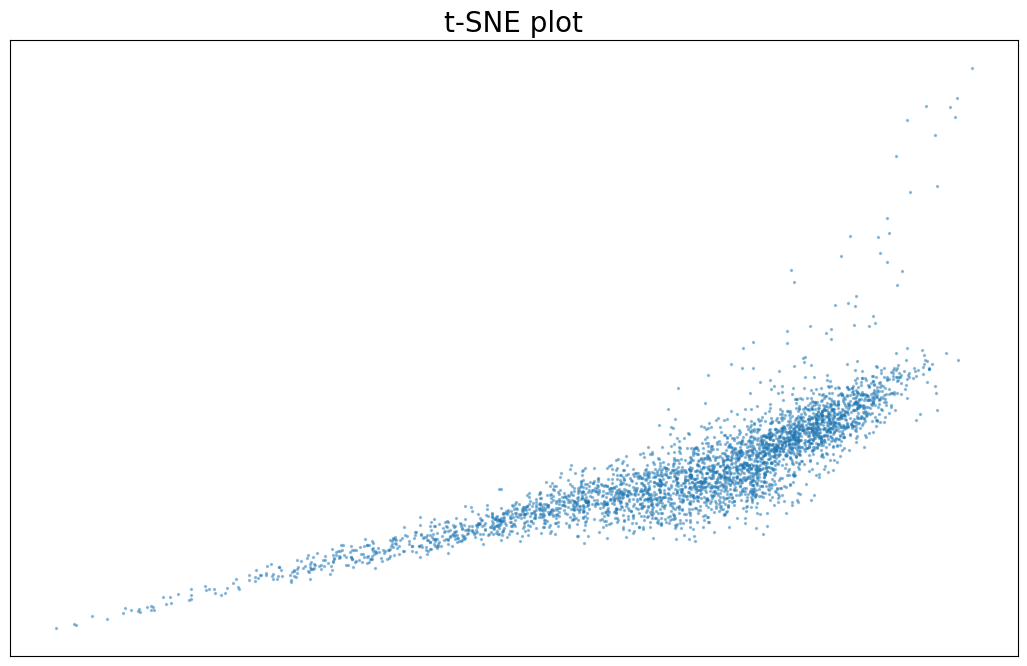

In [38]:
plot_tsne(model, perplexity=40, learning_rate=5)

In [47]:
def plot_tsne_top_n(model, word, n:int = 10):
    
    """t-SNE plot for top n similar words for the given input
    
    Args:
        model : An object of Word2Vec class, created by get_or_build_model().
        word : the string we want to plot similar words for
        n : number of similar words we want to get [default = 10]   
    """
    
    X = model.wv[model.wv.key_to_index.keys()]
    tsne = TSNE(n_components=2,
                  perplexity=20,
                  learning_rate=10,
                  n_iter=1000,
                  metric='euclidean')

    X_tsne = tsne.fit_transform(X)

    tsne_df = pd.DataFrame([X_tsne[:, 0], X_tsne[:, 1]]).T
    tsne_df.columns = ['X', 'Y']

    tsne_df['words'] = model.wv.key_to_index.keys()

    top = [x[0] for x in model.wv.most_similar(positive=[word], topn=n)]


    df_point = tsne_df[tsne_df.words == word].reset_index(drop=True)
    df_1 = tsne_df[tsne_df.words.isin(top)].reset_index(drop=True)
    plt.scatter(df_1.X, df_1.Y)
    plt.scatter(df_point.X, df_point.Y, c='r')
    texts = [plt.text(df_1.X[i], df_1.Y[i], df_1.words[i], ha='center', va='center',alpha=0.5) for i in range(len(df_1))]
    adjust_text(texts)
    plt.text(df_point.X[0], df_point.Y[0], df_point.words[0], horizontalalignment='center')
    plt.title(f'Top {n} words for {word}', fontsize=20)
    plt.show()

A method similar to t-sne which can be used to visualize high-dimentional data is UMAP which stands for __Uniform Manifold Approximation and Projection__. The followign description is taken from its [official documentation](https://umap-learn.readthedocs.io/en/latest/):

_"Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. The algorithm is founded on three assumptions about the data"_

The main diference between t-sne and UMAP - accorfing to authors of UMAP - is that unlike t-sne, UMAP considers not only the local but also the global structure of data. (take a look at this nice [answer](https://stats.stackexchange.com/a/402676/105874) post)

Ok, let's try it out:

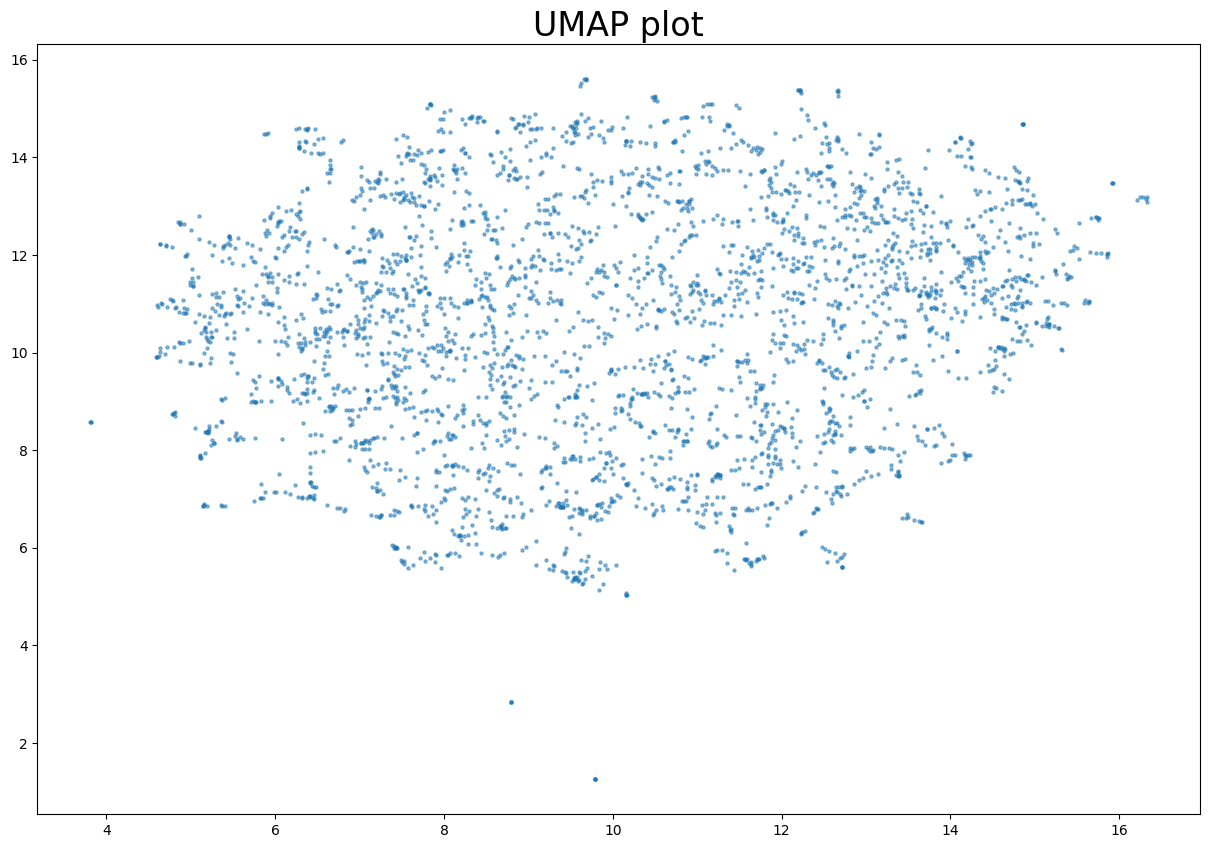

In [48]:
plot_umap(model)

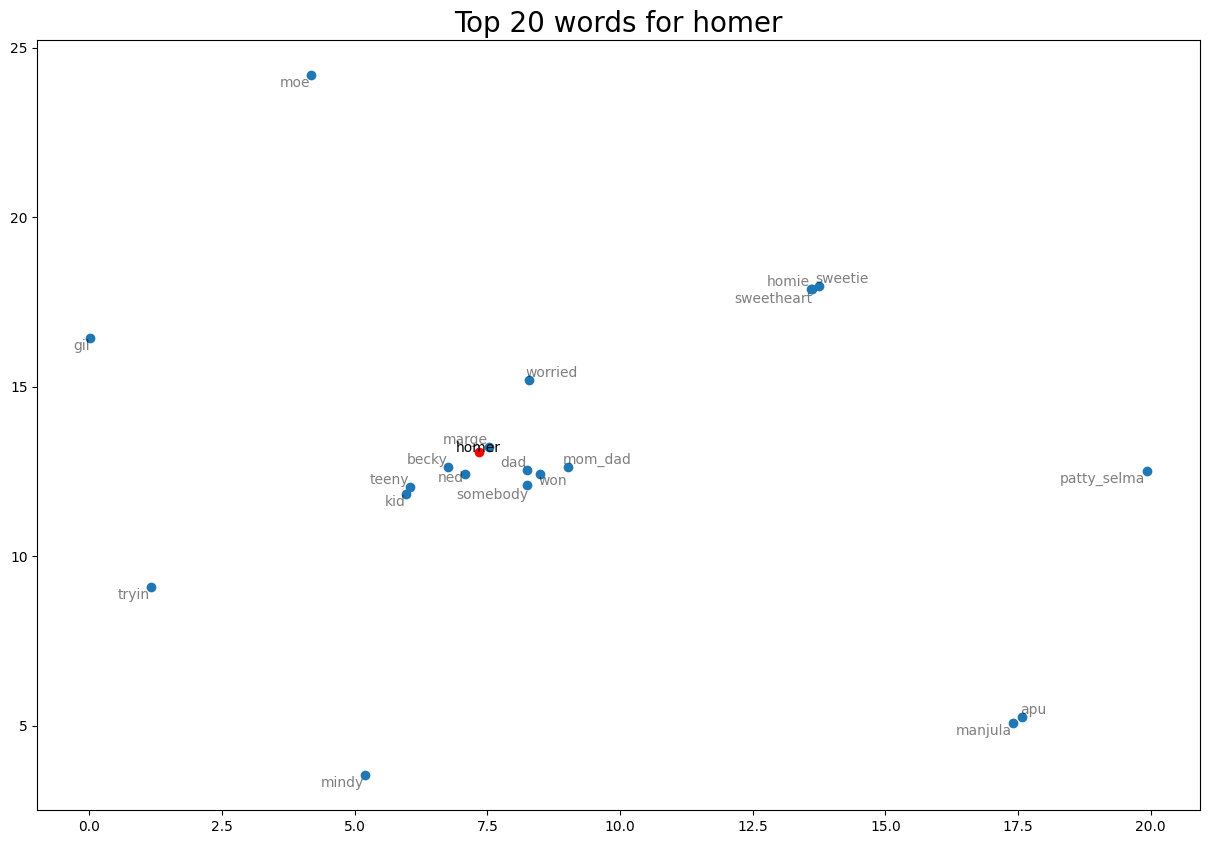

In [49]:
plot_tsne_top_n(model, 'homer', n=20)

In [50]:
def plot_umap_top_n(model, word, n:int = 10):
    
    """UMAP plot for top n similar words for the given input
    
    Args:
        model : An object of Word2Vec class, created by get_or_build_model().
        word : the string we want to plot similar words for
        n : number of similar words we want to get [default = 10]   
    """
    
    X = model.wv[model.wv.key_to_index.keys()]
    reducer = umap.UMAP()
    X_tsne = reducer.fit_transform(X)


    tsne_df = pd.DataFrame([X_tsne[:, 0], X_tsne[:, 1]]).T
    tsne_df.columns = ['X', 'Y']

    tsne_df['words'] = model.wv.key_to_index.keys()

    top = [x[0] for x in model.wv.most_similar(positive=[word], topn=n)]


    df_point = tsne_df[tsne_df.words == word].reset_index(drop=True)
    df_1 = tsne_df[tsne_df.words.isin(top)].reset_index(drop=True)
    plt.scatter(df_1.X, df_1.Y)
    plt.scatter(df_point.X, df_point.Y, c='r')
    
    texts = [plt.text(df_1.X[i], df_1.Y[i], df_1.words[i], ha='center', va='center',alpha=0.5) for i in range(len(df_1))]
    adjust_text(texts)


    plt.text(df_point.X[0], df_point.Y[0], df_point.words[0], horizontalalignment='center')
    plt.title(f'Top {n} words for {word}', fontsize=20)
    plt.show()

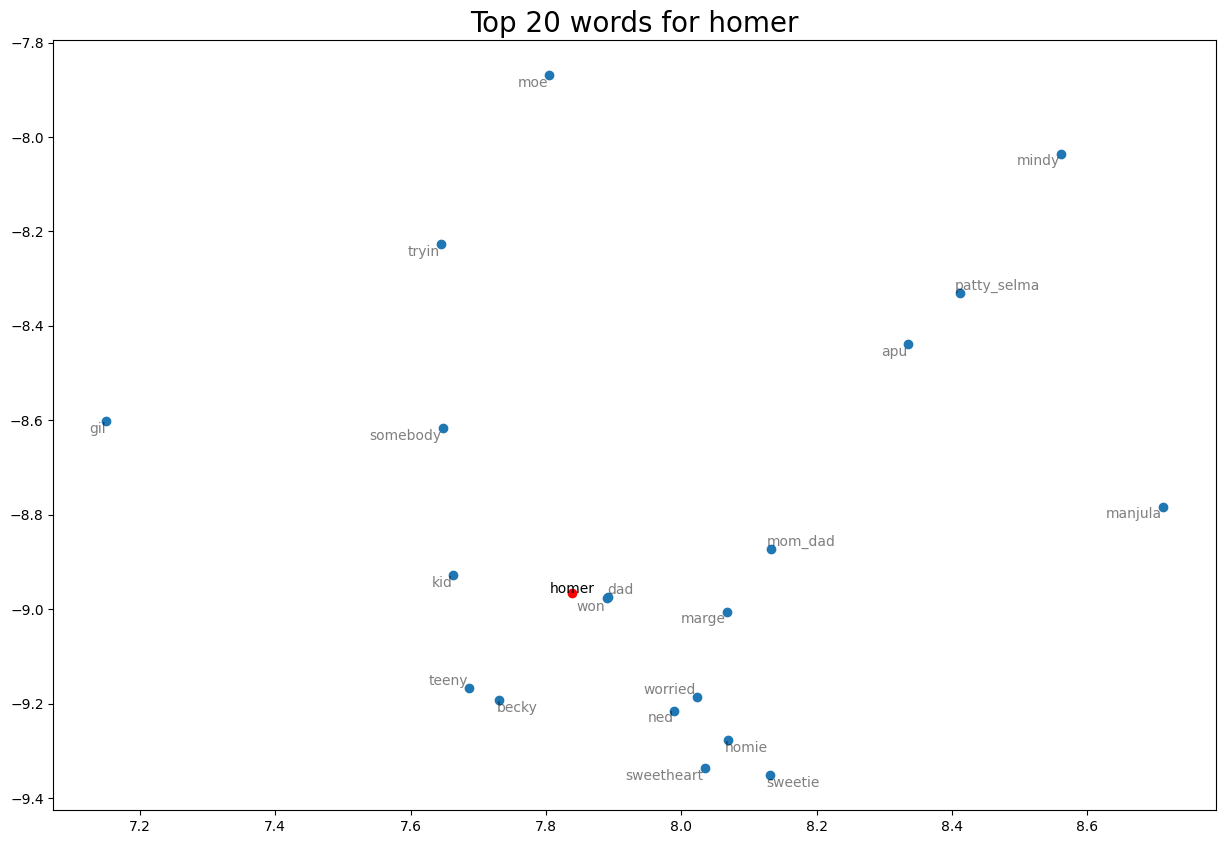

In [51]:
plot_umap_top_n(model, 'homer', n=20)

## Doc2Vec Algorithm

Now that you know the concept of word embeddings and the Word2Vec algorithm, it's easier to talk about Doc2Vec.

Doc2Vec is a generalization of a Word2Vec algorithm that takes into consideration the context of words and the document as a whole.

In the doc2vec architecture, the two algorithms that are **“continuous bag of words” (CBOW)** and **“skip-gram” (SG)**; correspond to the **“distributed memory” (DM)** and **“distributed bag of words” (DBOW)**.

The following figure shows how  Word2Vec integrates the Document ID into the context:


<img src="Images/doc2vec.jpg" height="300" width="800">

### Data preparation

While in Word2Vec example we used embeddings to create a visualization, in case of Doc2Vec we try to create a simple classifier which given a sentence can predict who's sentence is that!

To do so we need to do a further step: **Balancing the data**

In [52]:
# normalizing the names
df['raw_character_text'] = [x.lower().strip() for x in df['raw_character_text']]

In [53]:
df.raw_character_text.value_counts()[:4]

raw_character_text
homer simpson    27850
marge simpson    13172
bart simpson     12995
lisa simpson     10756
Name: count, dtype: int64

As you can see **Lisa** has the lowest lines : 10756 . One way to balance the data is down sample others to Lisa level:

In [54]:
data_ho = df[df.raw_character_text == 'homer simpson'].sample(10756)
data_ma = df[df.raw_character_text == 'marge simpson'].sample(10756)
data_ba = df[df.raw_character_text == 'bart simpson'].sample(10756)
data_li = df[df.raw_character_text == 'lisa simpson']

Now we should individually divide data for each character to train and test and then combine them together.

In [55]:
data_ho_test = data_ho.sample(3226)
data_ho_train = data_ho[~data_ho.index.isin(data_ho_test.index)]

In [56]:
data_ma_test = data_ma.sample(3226)
data_ma_train = data_ma[~data_ma.index.isin(data_ma_test.index)]

In [57]:
data_ba_test = data_ba.sample(3226)
data_ba_train = data_ba[~data_ba.index.isin(data_ba_test.index)]

In [58]:
data_li_test = data_li.sample(3226)
data_li_train = data_li[~data_li.index.isin(data_li_test.index)]

In [59]:
# Training data
data_train = pd.concat([data_ho_train, data_ma_train, data_ba_train, 
                      data_li_train]).reset_index(drop=True)

In [60]:
# Testing data
data_test = pd.concat([data_ho_test, data_ma_test, data_ba_test, 
                      data_li_test]).reset_index(drop=True)

In [61]:
# Tagging each document with its label
train_tagged = data_train.apply(lambda x: TaggedDocument(words=text_preproc(x['spoken_words']), tags=[x.raw_character_text]), axis=1)
test_tagged = data_test.apply(lambda x: TaggedDocument(words=text_preproc(x['spoken_words']), tags=[x.raw_character_text]), axis=1)

In [62]:
# an example
train_tagged.values[42]

TaggedDocument(words=['know', 'hate', 'church', 'boring', 'sermons'], tags=['homer simpson'])

As we mentioned before, in order to create a Doc2Vec model we have two options. Let's start from DBOW model:

In [63]:
# Inizializing the Doc2Vec model and creating the vocabulary
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=30, hs=0, min_count=6)
model_dbow.build_vocab([x for x in tqdm_notebook(train_tagged.values)])

  0%|          | 0/30120 [00:00<?, ?it/s]

In [64]:
# training the model in 30 epochs
for epoch in tqdm_notebook(range(30), desc= 'Training model'):
    model_dbow.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

Training model:   0%|          | 0/30 [00:00<?, ?it/s]

In [67]:
def labeled_vectors(model:Doc2Vec,
                     tagged_docs:pd.core.series.Series):
    """Tagged vectors for the given model and documnets
    
    Args:
        model: trained Doc2Vec model
        tagged_docs: A pandas.Series which contains tagged documenst with their labels
        
    Returns:
        labels and vectors for the giben documents
        
    """
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [68]:
y_train, X_train = labeled_vectors(model_dbow, train_tagged)
y_test, X_test = labeled_vectors(model_dbow, test_tagged)
logreg = LogisticRegression(C=1e10)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 4)}')
print(f'F1 score: {round(f1_score(y_test, y_pred, average="weighted"),4)}')

Accuracy: 0.2633
F1 score: 0.2574


In [69]:
model_dm = Doc2Vec(dm=1, window=3, vector_size=300, negative=30, min_count=6,alpha=0.1, min_alpha=0.1)
model_dm.build_vocab([x for x in train_tagged.values])

In [70]:
# training the model in 30 epochs
for epoch in tqdm_notebook(range(30), desc= 'Training model'):
    model_dm.train(utils.shuffle([x for x in train_tagged.values]), total_examples=len(train_tagged.values), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

Training model:   0%|          | 0/30 [00:00<?, ?it/s]

In [71]:
y_train, X_train = labeled_vectors(model_dm, train_tagged)
y_test, X_test = labeled_vectors(model_dm, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 4)}')
print(f'F1 score: {round(f1_score(y_test, y_pred, average="weighted"),4)}')

Accuracy: 0.3072
F1 score: 0.305


According to creators of gensim library combining a paragraph vector from Distributed Bag of Words (DBOW) and Distributed Memory (DM) improves performance.

In [75]:
# concatenating models
new_model = ConcatenatedDoc2Vec([model_dbow, model_dm])

In [76]:
y_train, X_train = labeled_vectors(new_model, train_tagged)
y_test, X_test = labeled_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 4)}')
print(f'F1 score: {round(f1_score(y_test, y_pred, average="weighted"),4)}')

Accuracy: 0.307
F1 score: 0.3048


The results are way better than before but still can't be considered as good results. The biggest problem is the size of the training data. Another reason may be the way we have addressed the _unbalanced_ data. A better way to do so would be using a method like __SMOTE__ to do the under or over sampling.

## Sources

* [Distributed Representations of Words and Phrases and their Compositionality (Milkov et al)](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
* [Gensim documentation](https://radimrehurek.com/gensim/index.html)
* [RaRe-Technologies Github Page](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb)
* [Multi-Class Text Classification with Doc2Vec & Logistic Regression by Susan Li](https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4)
* [Gensim Word2Vec Tutorial by Pierre Megret](https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial)
* [An Artificial Language Evaluation of Distributional Semantic Models](https://www.aclweb.org/anthology/K17-1015.pdf)